# Compare sentence embedding result of VADER, TextBlob, and RoberTa on MELD dataset

In [1]:
import vaderSentiment
import textblob
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AutoModel
from scipy.special import softmax
import pandas as pd
#load model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model_sentiment = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:

train = pd.read_csv("C:/Users/NA/Saved Games/dataset/MELD.Raw/MELD.Raw/train/train_sent_emo.csv")
X_raw = train['Utterance']
y_raw = train['Sentiment']
y_raw = y_raw.map({'neutral': 0, 'negative': -1, 'positive': 1})
y_raw


0       0
1       0
2       0
3       0
4       1
       ..
9984    0
9985    0
9986    1
9987    0
9988    1
Name: Sentiment, Length: 9989, dtype: int64

In [6]:
type(X_raw)

pandas.core.series.Series

# roberta classify text

In [7]:
all_scores = []
input_vector = []
for sentence in X_raw:
    encoded_input = tokenizer(sentence, return_tensors='pt')
    output = model_sentiment(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    all_scores.append(scores)

In [8]:
# select the most dominat probability and make new column for class
score_roberta = pd.DataFrame(all_scores, columns=['negative', 'neutral', 'positive'])
score_roberta['label'] = score_roberta.apply(lambda x: x.idxmax(), axis=1)
score_roberta['label'] = score_roberta['label'].map({'neutral': 0, 'negative': -1, 'positive': 1})
#score_roberta['label'].to_csv("score_roberta.csv")

In [14]:
score_roberta['label']

0       0
1       0
2       0
3       0
4       0
       ..
9984    0
9985    0
9986   -1
9987    0
9988    1
Name: label, Length: 9989, dtype: int64

# Vader classify text

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment = []
for sentence in X_raw:
    vs = analyzer.polarity_scores(sentence)
    sentiment.append(vs)

score_vader = pd.DataFrame(sentiment)
score_vader['3class_vad'] = score_vader['compound'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))

In [13]:
score_vader['3class_vad']

0       0
1       0
2       0
3       0
4       0
       ..
9984    0
9985    0
9986    0
9987    1
9988    1
Name: 3class_vad, Length: 9989, dtype: int64

# textblob classify text

In [10]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
sentiment_tb = []
sentiment_textblob = pd.DataFrame()
for sentence in X_raw:
    object_ = TextBlob(sentence)
    sentiment_tb.append(object_.sentiment.polarity)
sentiment_textblob['compond'] = pd.DataFrame(sentiment_tb)

sentiment_textblob['3class_tb'] = sentiment_textblob['compond'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))

In [16]:
sentiment_textblob['3class_tb'], score_vader['3class_vad'], score_roberta['label']

(0       0
 1       1
 2       0
 3      -1
 4       1
        ..
 9984    0
 9985    0
 9986    1
 9987    0
 9988    1
 Name: 3class_tb, Length: 9989, dtype: int64,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9984    0
 9985    0
 9986    0
 9987    1
 9988    1
 Name: 3class_vad, Length: 9989, dtype: int64,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9984    0
 9985    0
 9986   -1
 9987    0
 9988    1
 Name: label, Length: 9989, dtype: int64)

# Performance evaluation

## function

In [11]:
import numpy as np
import pandas as pd

def build_confusion_matrix(y_true, y_pred, labels=None, display=True):
    """
    Build confusion matrix (counts) for given labels.
    y_true, y_pred: 1D iterables (lists or numpy arrays) of same length.
    labels: optional list/array specifying class order (e.g. [-1.0, 0.0, 1.0] or [0,1,2]).
            If None, labels = sorted unique values from y_true ∪ y_pred.
    Returns: (cm, labels) where cm is a numpy array shape (K,K) with rows=true, cols=pred.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    else:
        labels = np.asarray(labels)

    K = len(labels)
    label_to_index = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((K, K), dtype=int)

    for t, p in zip(y_true, y_pred):
        # handle unseen labels gracefully
        if t in label_to_index and p in label_to_index:
            cm[label_to_index[t], label_to_index[p]] += 1
        else:
            # optional: count/ignore unknown labels
            pass

    if display:
        df = pd.DataFrame(cm, index=[f"true={l}" for l in labels],
                          columns=[f"pred={l}" for l in labels])
        print("Confusion matrix (counts):")
        print(df)
        # Metrics
        accuracy = np.trace(cm) / cm.sum() if cm.sum() > 0 else 0.0
        print(f"\nOverall accuracy: {accuracy:.4f}")

        # per-class precision, recall, f1
        precisions = []
        recalls = []
        f1s = []
        for i, lab in enumerate(labels):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
            precisions.append(prec)
            recalls.append(rec)
            f1s.append(f1)
            print(f"Class {lab}: precision={prec:.3f}, recall={rec:.3f}, f1={f1:.3f}")

        print(f"\nMacro F1: {np.mean(f1s):.4f}")
    return cm, labels



In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def plot_confusion_matrix(cm,
                          labels,
                          out_name,
                          normalize=None,     # None | 'true' | 'pred' | 'all'
                          figsize=(7,6),
                          cmap='Blues',
                          fmt='.2f',
                          annot_size=12,
                          title=None,
                          show_metrics=True,
                          savepath=None):
    """
    Pretty confusion matrix plot using seaborn.
    - cm: integer numpy array shape (K, K), rows=true, cols=pred
    - labels: list of K labels (strings) in the order of the matrix
    - normalize: None | 'true' (row-wise recall) | 'pred' (col-wise) | 'all' (global)
    - savepath: if given, saves the figure to this path (png/pdf).
    """
    cm = np.asarray(cm).astype(int)
    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError("cm must be a square (K,K) matrix")

    # compute display matrix
    disp = cm.astype(float)
    if normalize == 'true':
        row_sums = disp.sum(axis=1, keepdims=True)
        # avoid divide-by-zero
        row_sums[row_sums == 0] = 1
        disp = disp / row_sums
        annot_fmt = fmt
    elif normalize == 'pred':
        col_sums = disp.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1
        disp = disp / col_sums
        annot_fmt = fmt
    elif normalize == 'all':
        total = disp.sum()
        total = total if total != 0 else 1
        disp = disp / total
        annot_fmt = fmt
    else:
        # no normalization: show counts, but also show percent text below
        annot_fmt = 'd'

    K = len(labels)

    # Build annotation strings: show "count\n(percentage)" or just count/percent depending on normalize
    annot = np.empty_like(disp, dtype=object)
    total = cm.sum() if cm.sum() > 0 else 1
    for i in range(K):
        for j in range(K):
            count = cm[i, j]
            if normalize is None:
                pct = count / total
                annot[i, j] = f"{count}\n({pct:.1%})"
            else:
                annot[i, j] = f"{disp[i, j]:{annot_fmt}}"

    plt.figure(figsize=figsize)
    sns.set(style='white')
    ax = sns.heatmap(disp, annot=annot, fmt='', cmap=cmap, cbar=True,
                     xticklabels=labels, yticklabels=labels,
                     linewidths=.5, linecolor='gray', annot_kws={"size": annot_size})
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)

    # Compute summary metrics
    if show_metrics:
        y_true = []
        y_pred = []
        for i in range(K):
            for j in range(K):
                cnt = int(cm[i, j])
                if cnt > 0:
                    y_true.extend([labels[i]] * cnt)
                    y_pred.extend([labels[j]] * cnt)
        # If no examples at all, skip metrics
        if len(y_true) > 0:
            acc = accuracy_score(y_true, y_pred)
            prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
            # build a small summary string
            per_class_lines = [f"{lab}: P={p:.2f} R={r:.2f} F1={f:.2f}" for lab, p, r, f in zip(labels, prec, rec, f1)]
            summary = f"Accuracy: {acc:.3f}\n" + "\n".join(per_class_lines)
        else:
            summary = "No samples to compute metrics."
    else:
        summary = ""

    # Title placement
    if title is None:
        if normalize is None:
            nm = 'Counts (with global %)'
        else:
            nm = f"Normalized ({normalize})"
        title = f"Confusion Matrix — {out_name} {nm}"
    ax.set_title(title, fontsize=14, pad=12)

    # place metrics text on the right
    if show_metrics:
        plt.gcf().text(0.95, 0.5, summary, fontsize=10, va='center', ha='left', family='monospace')

    plt.tight_layout(rect=[0, 0, 0.94, 1])  # leave space on right for text

    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()


In [21]:
sentiment_textblob['3class_tb'], score_vader['3class_vad'], score_roberta['label']
cm_tb, labels_tb = build_confusion_matrix(sentiment_textblob['3class_tb'], y_raw, labels=[-1.0, 0.0, 1.0])

Confusion matrix (counts):
           pred=-1.0  pred=0.0  pred=1.0
true=-1.0        536       445       165
true=0.0        1744      2841      1235
true=1.0         665      1424       934

Overall accuracy: 0.4316
Class -1.0: precision=0.182, recall=0.468, f1=0.262
Class 0.0: precision=0.603, recall=0.488, f1=0.540
Class 1.0: precision=0.400, recall=0.309, f1=0.349

Macro F1: 0.3834


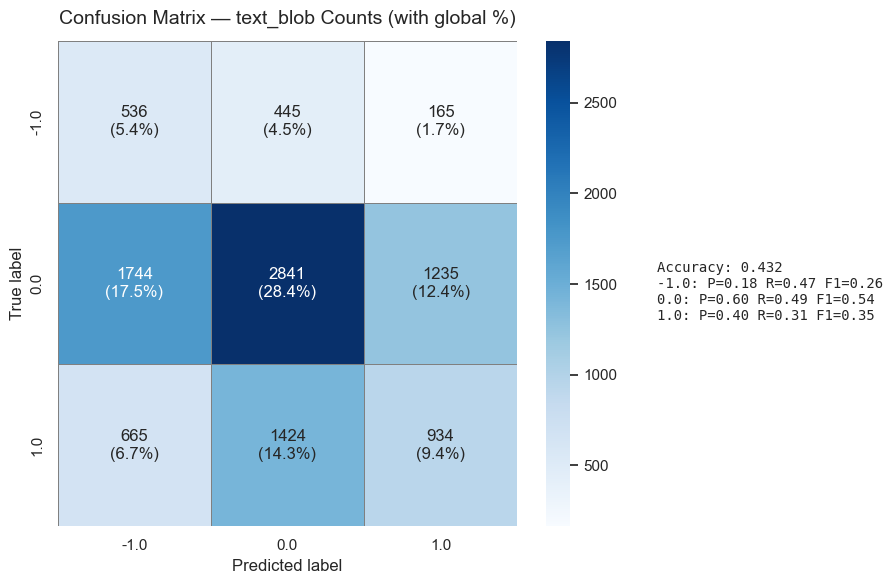

In [30]:
plot_confusion_matrix(cm_tb, labels_tb,out_name = "text_blob", figsize=(7,6))

In [ ]:
cm_vader, labels_vader = build_confusion_matrix(score_vader['3class_vad'], y_raw, labels=[-1.0, 0.0, 1.0])

Confusion matrix (counts):
           pred=-1.0  pred=0.0  pred=1.0
true=-1.0        718       400       178
true=0.0        1325      2467      1010
true=1.0         902      1843      1146

Overall accuracy: 0.4336
Class -1.0: precision=0.244, recall=0.554, f1=0.339
Class 0.0: precision=0.524, recall=0.514, f1=0.519
Class 1.0: precision=0.491, recall=0.295, f1=0.368

Macro F1: 0.4085


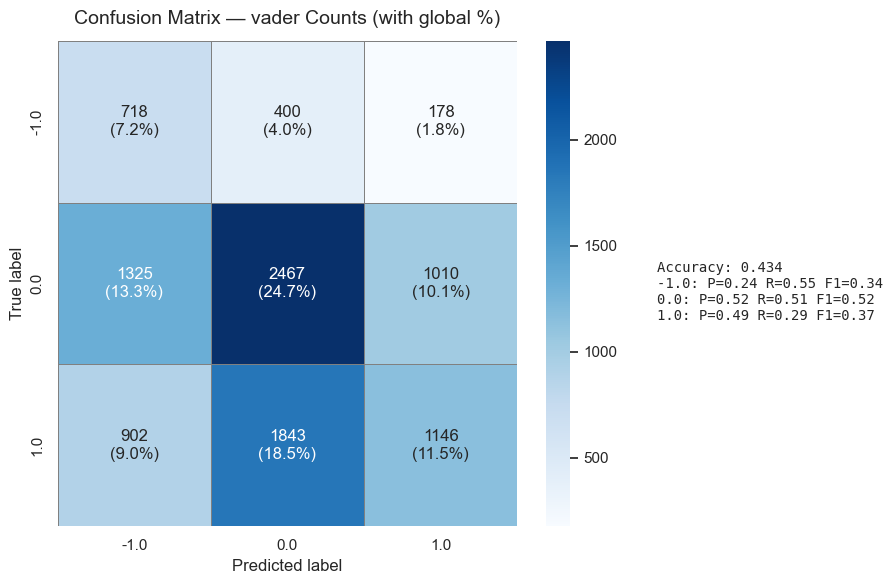

In [31]:
plot_confusion_matrix(cm_vader, labels_tb,out_name = "vader", figsize=(7,6))

Confusion matrix (counts):
           pred=-1.0  pred=0.0  pred=1.0
true=-1.0       1364       573       267
true=0.0        1106      3374       715
true=1.0         475       763      1352

Overall accuracy: 0.6097
Class -1.0: precision=0.463, recall=0.619, f1=0.530
Class 0.0: precision=0.716, recall=0.649, f1=0.681
Class 1.0: precision=0.579, recall=0.522, f1=0.549

Macro F1: 0.5867


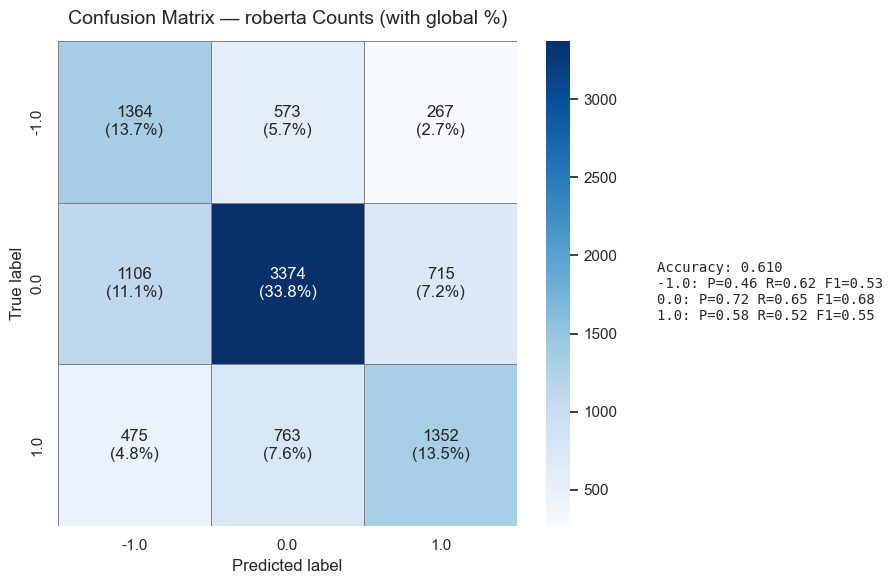

In [32]:
cm_robert, labels_robert = build_confusion_matrix(score_roberta['label'], y_raw, labels=[-1.0, 0.0, 1.0])
plot_confusion_matrix(cm_robert, labels_robert,out_name = "roberta", figsize=(7,6))